In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as lay
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import stellargraph as sg
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import GCNSupervisedGraphClassification
from stellargraph import StellarGraph
from stellargraph import datasets

from IPython.display import display, HTML

For this task I will train two different Graph based models on the jet data for binary classification. 
For The first model I use a Graph Convolutional Network, where I use k nearest neighboars to set initial edges of the graph.
For the second method I adapt the EdgeConv method to build a Graph classifier for the point data.
To try a fair comparasion I try to keep the number of parameters of both models roughly the same and use comparable training setups.

# Method 1: GCN

As first method I use a Graph Convolutional Network

## Data

I store the files of the dataset in the data directory and combine the data from the different files there.

In [2]:
from os import walk

f = []
for (dirpath, dirnames, filenames) in walk("jet_data"):
    f.extend(filenames)
    break

I use stellargraph (https://github.com/stellargraph/stellargraph) for the graph handling.
To construct the graph I use a vertex per jet so that the number of vertices equals the jet multiplicity.  
The vertex features are all features from the dataset namely transverse momentum, rapidity, azimuthal angle and the particle id.  
I want to map the data to a homogenous graph without edge features. I want to connect the nodes that are closest in feature space as I assume they are closely realted. I do weight the edges. To do so I build the matrix A by using NearestNeighbors. The method make_graph builds a StellarGraph object from features of a single event.

In [3]:
from sklearn.neighbors import NearestNeighbors
def get_A(data):
    return NearestNeighbors(n_neighbors=4, algorithm='ball_tree').fit(data).kneighbors_graph(data).toarray()

Stellargraph takes the edges in the form of a pandas Dataframe. Therefore I cast the graphs matrix using np.where to find the indices of 1 entries in the matrix.


In [4]:
def make_graph(feats):
    A = get_A(feats)
    idxs = np.where(A > 0)
    square_numeric_edges = pd.DataFrame(
    {"source": idxs[0], "target": idxs[1]}
    )
    return StellarGraph(feats, square_numeric_edges)

In [5]:
MAX_FILES = 3 #number of files to load (one file contains 100000 events)
FILE_EVENTS = 10000 # number of events to load per file (to train on small datasets for debug purposes)

def load_field(field):
    graphs = np.array([make_graph(features) for features in np.load("jet_data/"+f[0])[field][:FILE_EVENTS,:,:]])
    return graphs

In [6]:
gs = load_field('X') # array of graphs

labels are likewise loaded from the file 

In [7]:
graph_labels = pd.DataFrame(np.load("jet_data/"+f[0])['y'][:FILE_EVENTS])

build a generator from the graphs using StellarGraphs class

In [8]:
generator = PaddedGraphGenerator(graphs=gs)

## Model

Now I build a model. I use a Graph Convolutional Layer from Stellargraph (https://github.com/stellargraph/stellargraph/blob/develop/stellargraph/layer/gcn.py) which is based on 1902.06673.
After the Graph convolutional architecture 3 Dense layers follow. Last layer gets sigmoid activation for binary classification. 
The model is compiled with binary crossentropy, optimizer is Adam. I use some dropout for regularization.

In [9]:
gc_model = GCNSupervisedGraphClassification(
    layer_sizes=[128, 64, 32],
    activations=["relu", "relu", "relu"],
    generator=generator,
    dropout=0.4,
)
x_inp, x_out = gc_model.in_out_tensors()
x = Dense(units=64, activation="relu")(x_out)
x = Dense(units=32, activation="relu")(x)
x = Dense(units=1, activation="sigmoid")(x)

# Let's create the Keras model and prepare it for training
model = Model(inputs=x_inp, outputs=x)
model.compile(optimizer=Adam(0.005), loss=binary_crossentropy, metrics=["acc"])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 4)]    0           []                               
                                                                                                  
 dropout (Dropout)              (None, None, 4)      0           ['input_1[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, None, None)  0           []                               
                                ]                                                                 
                                                                                                  
 graph_convolution (GraphConvol  (None, None, 128)   640         ['dropout[0][0]',            

## Training

Set the training parameters. I use early stopping on the validation loss.

In [11]:
epochs = 100 
batch_size = 64
early_stopping = EarlyStopping(
    monitor="val_loss", patience=15
)

Build Training and Validation and Test generators.
I use 80\% for training, 10\% for validation and 10\% for testing

In [12]:
len_data = generator.graphs.shape[0]
len_train = int(0.8*len_data)
len_val = int(0.9*len_data)

train_gen = generator.flow(
    np.arange(len_train), targets=graph_labels.iloc[np.arange(len_train)].values, batch_size=batch_size
)

val_gen = generator.flow(
    np.arange(len_train, len_val), targets=graph_labels.iloc[np.arange(len_train, len_val)].values, batch_size=batch_size
)

test_gen = generator.flow(
    np.arange(len_val, len_data), targets=graph_labels.iloc[np.arange(len_val, len_data)].values, batch_size=batch_size
)


In [13]:
history = model.fit(
        train_gen, epochs=epochs, callbacks=[early_stopping], validation_data=val_gen
    )

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
125/125 [==============================] - ETA: 0s - loss: 0.6271 - acc: 0.6596WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f8d614ace60> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and at

## Evaluation 

We can see the acc on the test set lies between 75\% and 80\%

In [14]:
test_metrics = model.evaluate(test_gen, verbose=0)
test_acc = test_metrics[model.metrics_names.index("acc")]
test_acc

0.7760000228881836

Training plots

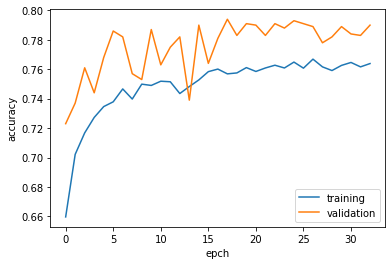

In [15]:
plt.plot(history.history['acc'], label="training")
plt.plot(history.history['val_acc'], label="validation")
plt.xlabel("epch")
plt.ylabel("accuracy")
plt.legend()

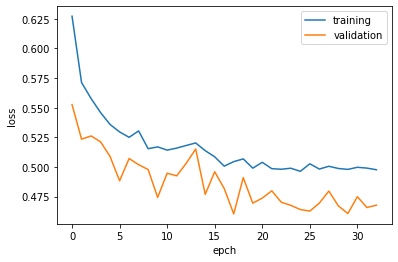

In [16]:
plt.plot(history.history['loss'], label="training")
plt.plot(history.history['val_loss'], label="validation")
plt.xlabel("epch")
plt.ylabel("loss")
plt.legend()

Calculate AUC

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


/home/tom/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


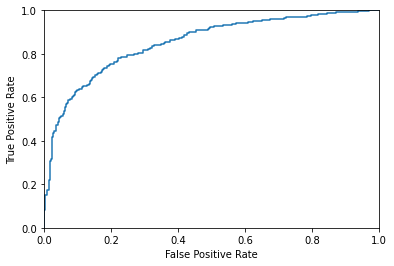

In [17]:
y_val_cat_prob = model.predict_generator(test_gen)
from sklearn.metrics import roc_curve,roc_auc_score

fpr , tpr , thresholds = roc_curve (graph_labels.iloc[np.arange(len_val, len_data)].values, y_val_cat_prob)

plt.plot(fpr,tpr) 
plt.axis([0,1,0,1]) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.show()

The AUC reaches 85\%

In [19]:
auc_score = roc_auc_score(graph_labels.iloc[np.arange(len_val, len_data)].values, y_val_cat_prob)  
auc_score

0.8520308973788536

# Method 2: EdgeConv

For the second method I searched through the literature for methods to map point data to graphs, to compare the GCN approach to a state of the art method for such a problem.  
I decided to try EdgeConv from 1801.07829. 

As coordinates of a single jet i use the rapidity and the azimuthal angle (extrinsic features)
The pt and particle Id are node features (intrinsic features).

## Data

I again load the data from multiple files in the directory.
This time I just load all the data into one array.  
This might be improved by using generators.  

As the data in different files has different sizes due to different maximal jet multiplicites I use some fiddeling to always scale the array for the whole data to the size of the largest multiplicity among the different files.

In [3]:
MAX_FILES = 3
FILE_EVENTS = 10000

def load_field(field):
    data = np.load("jet_data/"+f[0])[field]
    max_multiplicity = data.shape[1]
    #combined_data = np.array([np.load("jet_data/"+fname)[field] for fname in f[:8]])
    for fs in f[1:MAX_FILES]:
        data_tmp = np.load("jet_data/"+fs)[field]
        multiplicity = data_tmp.shape[1]
        print(fs,": ", data.shape, " - Max_mulit: ", max_multiplicity, " - mult: ", multiplicity)
        if max_multiplicity < multiplicity:
            max_multiplicity = multiplicity
            data = np.concatenate([data, np.zeros((data.shape[0],multiplicity - data.shape[1],data.shape[2]))],axis=1)
            data = np.concatenate([data,data_tmp],axis=0)
        else:
            data_tmp = np.concatenate([data_tmp, np.zeros((data_tmp.shape[0],max_multiplicity - data_tmp.shape[1],data_tmp.shape[2]))],axis=1)
            data = np.concatenate([data,data_tmp],axis=0)
        
    return data

In [4]:
X = load_field('X')
y = np.concatenate([np.load("jet_data/"+fs)['y'] for fs in f[:MAX_FILES]])

print("y: ", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.12)

print("X_train: ", X_train.shape)
print("X_val: ", X_val.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_val: ", y_val.shape)
print("y_test: ", y_test.shape)

print("feature shape: ", X_train[0].shape)

QG_jets_16.npz :  (100000, 139, 4)  - Max_mulit:  139  - mult:  136
QG_jets_13.npz :  (200000, 139, 4)  - Max_mulit:  139  - mult:  148
y:  (300000,)
X_train:  (237600, 148, 4)
X_val:  (32400, 148, 4)
X_test:  (30000, 148, 4)
y_train:  (237600,)
y_val:  (32400,)
y_test:  (30000,)
feature shape:  (148, 4)


## Model

For the Model I use the EdgeConv from 1801.07829.
I found an implementation for The EdgeConv Layer here https://git.rwth-aachen.de/niklas.langner/edgeconv_keras/-/tree/master, which I will be using in the following.

In [5]:
class SplitLayer(lay.Layer):
    """ Custom layer: split layer along specific axis.
    eg. split (1,9) into 9 x (1,1)

    Parameters
    ----------
    n_splits : int
        number of splits
    split_axis : int
        axis where to split tensor
    **kwargs : type
        Description of parameter `**kwargs`.

    Attributes
    ----------
    n_splits
    split_axis

    """

    def __init__(self, n_splits=12, split_axis=-1, **kwargs):
        self.n_splits = n_splits
        self.split_axis = split_axis
        super(SplitLayer, self).__init__(**kwargs)

    def get_config(self):
        config = {'n_splits': self.n_splits,
                  'split_axis': self.split_axis}
        base_config = super(SplitLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, x):
        ''' return array of splitted tensors '''
        sub_tensors = tf.split(x, self.n_splits, axis=self.split_axis)
        return sub_tensors

    def compute_output_shape(self, input_shape):
        sub_tensor_shape = list(input_shape)
        num_channels = sub_tensor_shape[self.split_axis]
        sub_tensor_shape[self.split_axis] = int(num_channels / self.n_splits)
        sub_tensor_shape = tuple(sub_tensor_shape)
        list_of_output_shape = [sub_tensor_shape] * self.n_splits
        return list_of_output_shape

    def compute_mask(self, inputs, mask=None):
        return self.n_splits * [None]


class EdgeConv(lay.Layer):
    '''
    Keras layer implementation of EdgeConv.
    # Arguments
        kernel_func: h-function applied on the points and it's k nearest neighbors. The function should take a list
            of two tensors. The first tensor is the vector v_i of the central point, the second tensor is the vector
            of one of its neighbors v_j.
            :param list: [v_i, v_j] with v_i and v_j being Keras tensors with shape (C_f, ).
            :return: Keras tensor of shape (C', ).
        next_neighbors: number k of nearest neighbors to consider
        agg_func: Aggregation function applied after h. Must take argument "axis=2" to
            aggregate over all neighbors.
    # Input shape
        List of two tensors [points, features] with shape:
        `[(batch, P, C_p), (batch, P, C_f)]`.
        or tensor with shape:
        `(batch, P, C)`
        if points (coordinates) and features are supposed to be the same.
    # Output shape
        Tensor with shape:
        `(batch, P, C_h)`
        with C_h being the output dimension of the h-function.
    '''

    def __init__(self, kernel_func, next_neighbors, agg_func=keras.backend.mean, **kwargs):
        self.kernel_func = kernel_func
        self.next_neighbors = next_neighbors
        self.agg_func = agg_func
        if type(agg_func) == str:
            raise ValueError("No such agg_func '%s'. When loading the model specify the agg_func '%s' via custom_objects" % (agg_func, agg_func))
        super(EdgeConv, self).__init__(**kwargs)

    def get_config(self):
        config = {'next_neighbors': self.next_neighbors,
                  'kernel_func': self.kernel_func,
                  'agg_func': self.agg_func}
        base_config = super(EdgeConv, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        try:
            p_shape, f_shape = input_shape
        except ValueError:
            f_shape = input_shape

        if type(self.kernel_func) != keras.models.Model:  # for not wrapping model around model when loading model
            x = lay.Input((f_shape.as_list()[-1] * 2,))
            a = lay.Reshape((2, f_shape.as_list()[-1]))(x)
            x1, x2 = SplitLayer(n_splits=2, split_axis=-2)(a)  # (2, C)
            x1 = lay.Reshape((f_shape.as_list()[-1],))(x1)
            x2 = lay.Reshape((f_shape.as_list()[-1],))(x2)
            y = self.kernel_func([x1, x2])
            self.kernel_func = keras.models.Model(x, y)

        super(EdgeConv, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        try:
            points, features = x
        except TypeError:
            points = features = x

        # distance
        D = batch_distance_matrix_general(points, points)  # (N, P, P)
        _, indices = tf.nn.top_k(-D, k=self.next_neighbors + 1)  # (N, P, K+1)
        indices = indices[:, :, 1:]  # (N, P, K) remove self connection
        knn_fts = knn(indices, features)  # (N, P, K, C)
        knn_fts_center = tf.tile(tf.expand_dims(features, axis=2), (1, 1, self.next_neighbors, 1))  # (N, P, K, C)
        knn_fts = tf.concat([knn_fts_center, knn_fts], axis=-1)  # (N, P, K, 2*C)
        res = lay.TimeDistributed(lay.TimeDistributed(self.kernel_func))(knn_fts)  # (N, P, K, C')
        # aggregation
        agg = self.agg_func(res, axis=2)  # (N, P, C')
        return agg

    def compute_output_shape(self, input_shape):
        self.output_shape = self.kernel_func.get_output_shape_at(-1)
        return self.output_shape


def batch_distance_matrix_general(A, B):
    ''' Calculate elements-wise distance between entries in two tensors '''
    with tf.name_scope('dmat'):
        r_A = tf.reduce_sum(A * A, axis=2, keepdims=True)
        r_B = tf.reduce_sum(B * B, axis=2, keepdims=True)
        m = tf.matmul(A, tf.transpose(B, perm=(0, 2, 1)))
        D = r_A - 2 * m + tf.transpose(r_B, perm=(0, 2, 1))
        return D


def knn(topk_indices, features):
    # topk_indices: (N, P, K)
    # features: (N, P, C)
    # return: (N, P, K, C)
    with tf.name_scope('knn'):
        k = tf.shape(topk_indices)[-1]
        num_points = tf.shape(features)[-2]
        queries_shape = tf.shape(features)
        batch_size = queries_shape[0]
        batch_indices = tf.tile(tf.reshape(tf.range(batch_size), (-1, 1, 1, 1)), (1, num_points, k, 1))
        indices = tf.concat([batch_indices, tf.expand_dims(topk_indices, axis=3)], axis=3)  # (N, P, K, 2)
        return tf.gather_nd(features, indices)

Choice of kernel function  
Number of dense units adjusted to get approximately 15k parameters for the whole model

In [6]:
def f(data):
    d1, d2 = data
    dif = lay.Subtract()([d1, d2])
    x = lay.Concatenate(axis=-1)([d1, dif])
    x = lay.Dense(64)(x)
    x = lay.Dense(32)(x)
    return x

Build model.
For the architecture I choose ....

In contrast to 1801.07829 and the implementation https://git.rwth-aachen.de/niklas.langner/edgeconv_keras/-/tree/master, I feed the output of the edgeconv layer into a global averagepooling, which in turn goes into dense layers, where the last layer only has one node for classification

In [7]:
points = lay.Input((X_train.shape[1],2))
feats = lay.Input((X_train.shape[1],2))
a = EdgeConv(f, next_neighbors=3)([points, feats])
y = EdgeConv(f, next_neighbors=3)(a)
oute = EdgeConv(f, next_neighbors=3)(y)
pool = lay.GlobalAveragePooling1D()(oute)
x = lay.Dense(64)(pool)
x = lay.Dense(32)(pool)
out = lay.Dense(1, activation="sigmoid")(x)

model = keras.models.Model([points, feats], out)
model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the ver

## Training

For training I again use adam and binarycrossentropy.  
Input for the model:   
point coordinates: rapidity and azimuthal angle: second and third features  
point features: pt and particle id: first and last features

In [8]:
model.compile(loss=keras.losses.BinaryCrossentropy(),
              optimizer=keras.optimizers.Adam(lr=0.005), 
              metrics=[keras.metrics.BinaryAccuracy()])

early_stopping = EarlyStopping(
    monitor="val_loss", patience=15
)
hist = model.fit([X_train[:,:,1:3], X_train[:,:,[0,3]]], y_train, batch_size=64, epochs=100, 
                 validation_data=([X_val[:,:,1:3],X_val[:,:,[0,3]]],y_val), callbacks=[early_stopping])

/home/tom/anaconda3/lib/python3.7/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
3713/3713 [==============================] - ETA: 0s - loss: 0.5957 - binary_accuracy: 0.6871WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f328e3a1ef0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSI

In [ ]:
# Evaluation

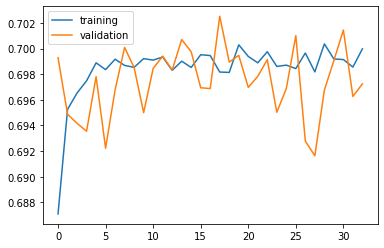

In [9]:
plt.plot(hist.history['binary_accuracy'], label="training")
plt.plot(hist.history['val_binary_accuracy'], label="validation")
plt.legend()

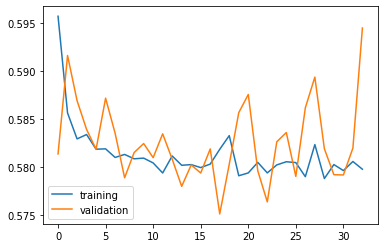

In [10]:
plt.plot(hist.history['loss'], label="training")
plt.plot(hist.history['val_loss'], label="validation")
plt.legend()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


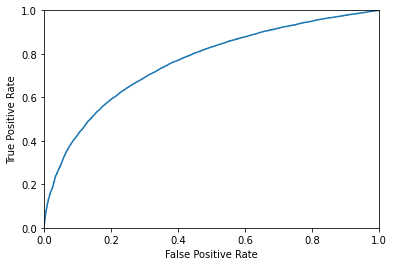

In [11]:
y_val_cat_prob = model.predict_on_batch([X_test[:,:,1:3], X_test[:,:,[0,3]]])
from sklearn.metrics import roc_curve,roc_auc_score

fpr , tpr , thresholds = roc_curve (y_test, y_val_cat_prob)

plt.plot(fpr,tpr) 
plt.axis([0,1,0,1]) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.show()

In [12]:
auc_score=roc_auc_score(y_test,y_val_cat_prob)  
auc_score

0.7612146679229965

# Comparison

The first model achieves a higher validation accuracy and a higher auc and espescially takes a lot less time to train.

